In [1]:
pip install osmnx geopandas folium matplotlib


In [3]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import folium

# Define city and POI types
city = "San Francisco, California, USA"
amenities = ["restaurant", "cafe", "school", "hospital"]

# Download city boundary
city_boundary = ox.geocode_to_gdf(city)

# Query POIs (new API call)
tags = {"amenity": amenities}
pois = ox.features_from_place(city, tags)

# Clean and filter
pois = pois[["amenity", "geometry"]].dropna(subset=["geometry"])
pois = pois[pois.geometry.type == "Point"]
pois_gdf = gpd.GeoDataFrame(pois, geometry="geometry", crs="EPSG:4326")

# Count POIs
print(pois_gdf["amenity"].value_counts())

# Create Map
sf_center = city_boundary.geometry.centroid.values[0].coords[0]
m = folium.Map(location=[sf_center[1], sf_center[0]], zoom_start=13)

for _, row in pois_gdf.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=3,
        popup=row["amenity"],
        color="blue" if row["amenity"] == "restaurant" else
              "green" if row["amenity"] == "cafe" else
              "red" if row["amenity"] == "school" else
              "purple",
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

# Save map
m.save("san_francisco_poi_map.html")
print("✅ Map saved to: san_francisco_poi_map.html")


amenity
restaurant    1712
cafe           718
school          74
hospital         4
Name: count, dtype: int64


<ipython-input-3-369222e24556>:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sf_center = city_boundary.geometry.centroid.values[0].coords[0]


✅ Map saved to: san_francisco_poi_map.html


In [7]:
#  STEP 2: Load SF Neighborhood GeoJSON
# --------------------------------------------
# Download from https://data.sfgov.org/api/geospatial/ejmn-jyk6?method=export&format=GeoJSON
# Save it as: sf_neighborhoods.geojson
neighborhoods = gpd.read_file("/content/sample_data/sf-neighborhoods-analysis.json")
neighborhoods = neighborhoods.rename(columns={"nhood": "Neighborhood"})
neighborhoods = neighborhoods[["Neighborhood", "geometry"]]
neighborhoods = neighborhoods.to_crs("EPSG:4326")


In [6]:
print(neighborhoods.columns)


Index(['nhood', 'geometry'], dtype='object')


In [8]:
# Ensure both layers use the same coordinate system
pois_gdf = pois_gdf.to_crs("EPSG:4326")
neighborhoods = neighborhoods.to_crs("EPSG:4326")

# Spatial join: assigns neighborhood to each POI
pois_with_neighborhood = gpd.sjoin(pois_gdf, neighborhoods, how="inner", predicate="within")

# Check result
print(pois_with_neighborhood[["amenity", "Neighborhood"]].head())


                      amenity     Neighborhood
element id                                    
node    281652642      school          Mission
        286132370  restaurant           Marina
        286898816      school   Bernal Heights
        293573361        cafe  Pacific Heights
        302448629  restaurant          Mission


In [9]:
# Group by neighborhood and amenity type
grouped = pois_with_neighborhood.groupby(["Neighborhood", "amenity"]).size().unstack().fillna(0)

# Show top neighborhoods for restaurants
print("Top neighborhoods by restaurant count:\n")
print(grouped["restaurant"].sort_values(ascending=False).head())

# (Optional) Save as CSV
grouped.to_csv("poi_counts_by_neighborhood.csv")


Top neighborhoods by restaurant count:

Neighborhood
Mission                           199.0
Financial District/South Beach    169.0
Chinatown                         121.0
Tenderloin                        118.0
Sunset/Parkside                    88.0
Name: restaurant, dtype: float64


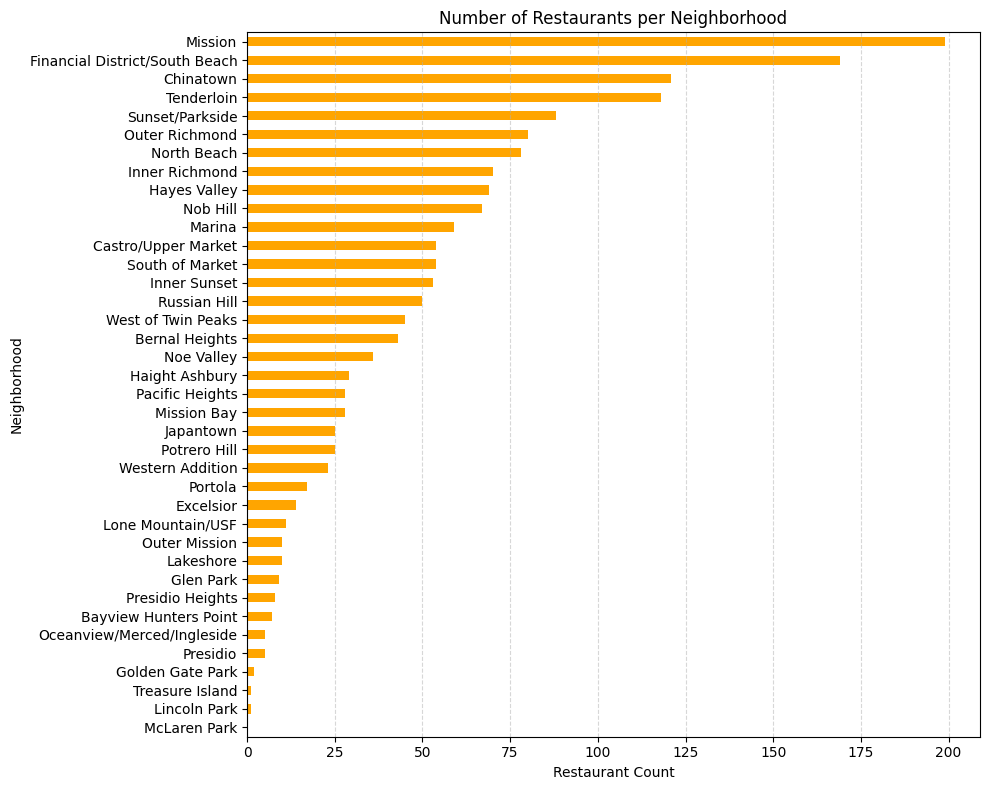

In [10]:
import matplotlib.pyplot as plt

# Sort and plot restaurant counts
grouped["restaurant"].sort_values(ascending=True).plot.barh(
    figsize=(10, 8), color="orange"
)

plt.title("Number of Restaurants per Neighborhood")
plt.xlabel("Restaurant Count")
plt.ylabel("Neighborhood")
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


In [11]:
import folium

# Merge restaurant counts back into the neighborhood GeoDataFrame
choropleth_df = neighborhoods.merge(grouped["restaurant"], on="Neighborhood", how="left").fillna(0)

# Create folium map centered on SF
sf_center = pois_gdf.geometry.unary_union.centroid
m = folium.Map(location=[sf_center.y, sf_center.x], zoom_start=12)

# Add choropleth
folium.Choropleth(
    geo_data=choropleth_df,
    data=choropleth_df,
    columns=["Neighborhood", "restaurant"],
    key_on="feature.properties.Neighborhood",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.3,
    legend_name="Restaurant Count by Neighborhood"
).add_to(m)

# Save map
m.save("sf_restaurant_choropleth_map.html")
print("✅ Choropleth map saved as sf_restaurant_choropleth_map.html")


✅ Choropleth map saved as sf_restaurant_choropleth_map.html


<ipython-input-11-dbb5da2d7956>:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  sf_center = pois_gdf.geometry.unary_union.centroid
